### This notebook demonstrates the application of a hidden Markov model (HMM) postprocessing step to a time series of Dynamic World LCLU class probability outputs

In this exercise we are chiefly concerned with understanding how a HMM postprocessing step (1) influences accuracy metrics against ground truth labels compared with standard Dynamic World class outputs; and (2) minimizes spurious year-to-year variability of class changes.  

The penultimate step of the Dynamic World land cover classification model normalizes each pixel from individual Sentinel-2 scenes into a probability distribution over predicted output classes. These intermediate outputs of class probability vectors can then be aggregated by year, with probabilities for each class arranged in separate bands. We treat these annual Dynamic World class probability vectors as the observed measurements $\left(x_{1:T}\right)$ in a hidden Markov model, and the time series of corresponding class labels $\left(y_{1:T}\right)$ as hidden states forming a Markov chain.  

Forward-backward inference computes marginal class probabilities considering user-provided transition probabilities. The forward pass ($\alpha$) computes joint probability between the current state variable ($y_t$) and all the observations up to this time step: $\alpha_t\left(y_t\right)=p\left(y_t, x_1,\dots, x_t\right)$. Then the backward pass $(\beta)$ computes conditional probability of all future observations ($x_{t+1}$) given the current state: $\beta_t\left(y_t\right)=p\left(x_{t+1},\dots,x_T\mid y_t\right)$.  

This is repeated for each pixel independently, and for each time step in the series to calculate the posterior marginal probabilities of the hidden Markov model being in each state at each step. Given the pixel observation sequence and conditional probability table (transition matrix), the output characterizes the most likely state for any point in time, which is separate from the most likely sequence of states (Viterbi algorithm). 

Execution of the HMM approach relies on the [MTLCHMM library](https://github.com/jgrss/mtlchmm) (version >= 0.1.0), ported from:  

> Abercrombie, S Parker and Friedl, Mark A (2016) [Improving the Consistency of Multitemporal Land Cover Maps Using a Hidden Markov Model](https://ieeexplore.ieee.org/document/7254169/). IEEE TRANSACTIONS ON GEOSCIENCE AND REMOTE SENSING, 54(2), 703--713.  

This notebook is organized as follows:  
- [Step 0: load libraries](#Step-0:-load-libraries-and-initialize-Earth-Engine)
- [Step 1: filter assets](#Step-1:-Select-and-filter-assets-and-review-metadata)
- [Step 2: process assets](#Step-2:-Preview-ground-truth-label-then-download-and-process-clipped-assets)
- [Step 3: run HMM postprocessing](#Step-3:-Set-HMM-params-and-run-HMM-forward-backward-process)
- [Step 4: evaluate against ground truth labels](#Step-4:-Evaluate-output-against-ground-truth-label)
- [Step 5: compare methods](#Step-5:-Compare-Dynamic-World-and-HMM-postprocessing-output)
- [Step 6: assess year-to-year change](#Step-6:-Characterize-change-and-year-to-year-class-stability)
- [Step 7: explore latent data](#Step-7:-Explore-latent-data-in-class-probability-distribution)


### Step 0: load libraries and initialize Earth Engine

In [1]:
import ee
import time
import datetime
import numpy as np
import pandas as pd
from sklearn import metrics
import rasterio as rio
from rasterio.plot import show_hist, show

# File management
import tempfile
import shlex
import glob
import os
import sys
# function below requires gdal in PATH (gdalwarp)
import subprocess

import mtlchmm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from wri_change_detection import hmm

### Step 1: Select and filter assets and review metadata

In [2]:
#some ee assets 
goldsboro_set = 'projects/wings-203121/assets/dynamic-world/v3-5_stack_tests/wri_test_goldsboro'
modesto_set = 'projects/wings-203121/assets/dynamic-world/v3-5_stack_tests/wri_test_modesto'
everglades_set = 'projects/wings-203121/assets/dynamic-world/v3-5_stack_tests/wri_test_everglades'
LABEL_COLLECTION = 'projects/wri-datalab/DynamicWorld_CD/DW_Labels'

label_filename = 'labels_tile.tif'
dwm_file_suffix = '_dwm_probas'

#tempfile
temp_dir_object = tempfile.TemporaryDirectory()
temp_dir = temp_dir_object.name

In [3]:
# select sample DWM collection consisting of band-separated class probability vectors
DW_PROBA_COLLECTION = goldsboro_set

# get image collection time range
collection = ee.ImageCollection(DW_PROBA_COLLECTION)
img_date_range = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"]).getInfo()
date_max = datetime.datetime.fromtimestamp(img_date_range['max']//1000).date()
date_min = datetime.datetime.fromtimestamp(img_date_range['min']//1000).date()
print(f'Collection includes ee images from {date_min.isoformat()} to {date_max.isoformat()}')

# filter to labels that intersect with image collection geometry
labels = ee.ImageCollection(LABEL_COLLECTION)
labels_filtered = labels.filterBounds(collection.geometry())
num_labels = labels_filtered.size().getInfo()
print('Number of labels that overlap classifications', num_labels)

# get first label in the list completely contained within the bounds of the collection
for i in range(0,num_labels):
    selected_labeled_img = ee.Image(labels_filtered.toList(labels_filtered.size()).get(i))
    label_contained = collection.geometry().contains(selected_labeled_img.geometry()).getInfo()
    if label_contained == True:
        print(f'selected label image {i+1} of {num_labels}')
        break
    else:
        time.sleep(0.5) # avoid getting too many infos

Collection includes ee images from 2015-12-16 to 2020-09-15
Number of labels that overlap classifications 3
selected label image 1 of 3


### Step 2: Preview ground truth label then download and process clipped assets

In [4]:
## To take directly from image collection time range: 
## 
# YEARS = range(date_min.year,date_max.year+1)

YEARS = range(2016,2021)

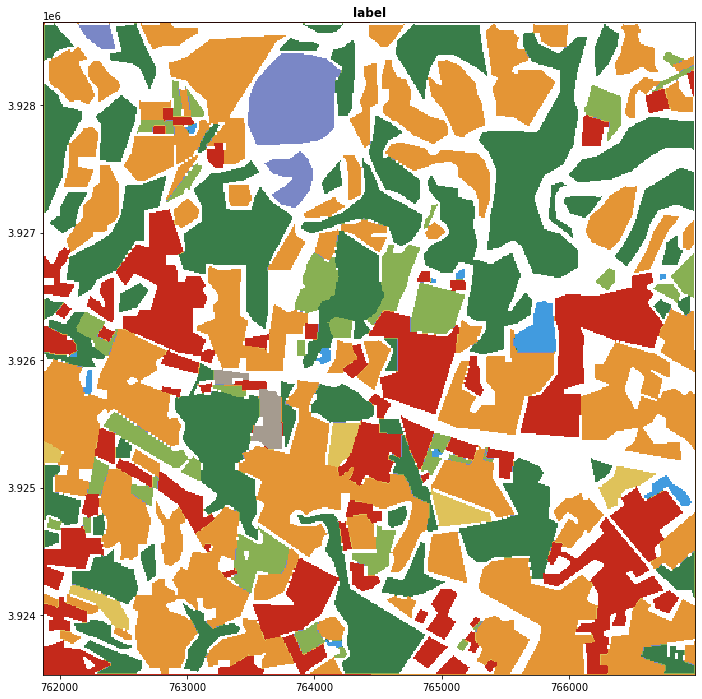

<AxesSubplot:title={'center':'label'}>

In [5]:
# write selected label tile and preview
hmm.write_block(selected_labeled_img,label_filename,temp_dir)
# create rasterio.io.DatasetReader object pointing to destination
labels_tile = rio.open(f'{temp_dir}/{label_filename}')
#show label tile
show(labels_tile,cmap=hmm.dw_class_cmap,norm=hmm.dw_norm,title='label')

In [6]:
# loop through downloading DW probability layers bounded by label tile shape
for i, year in enumerate(YEARS):
    print(f'{year}...',end='')
    img = hmm.retrieve_filtered_img(collection, year, selected_labeled_img)
    dst_filename = f'{year}{dwm_file_suffix}.tif'
    hmm.write_block(img,dst_filename,temp_dir)
    time.sleep(0.6)

2016...2017...2018...2019...2020...

In [7]:
# reproject downloaded DW probability geotiffs and match extent to label tile
list_to_reproj = sorted(glob.glob(f'{temp_dir}/*{dwm_file_suffix}.tif'))
labels_tile = rio.open(f'{temp_dir}/{label_filename}')
w,s,e,n = labels_tile.bounds
target_crs = labels_tile.crs.to_string()
cwd = os.getcwd()
for i in list_to_reproj:
    out_dst = f'{i[:-4]}_reproj.tif'
    cmd = f'gdalwarp {i} {out_dst} -t_srs {target_crs} -r near -tr 10 10 -te {w} {s} {e} {n} -overwrite'
    posix_cmd = shlex.split(cmd, posix=True)
    subprocess.check_call(posix_cmd, cwd=cwd)

### Step 3: Set HMM params and run HMM forward-backward process

In [8]:
# set up parameters for multi-temporal land change hidden markov model
transition_prior = 0.1

### Uncomment below for alternative transition priors, 
###     adapted from MapBiomas 1985-2018 class change matrix, 
###     for illustrative purposes 
# transition_prior = np.array([[0.867, 0.05 , 0.011, 0.007, 0.043, 0.01 , 0.002, 0.001, 0.01 ],
#        [0.004, 0.832, 0.004, 0.001, 0.143, 0.006, 0.001, 0.   , 0.01 ],
#        [0.006, 0.053, 0.716, 0.004, 0.175, 0.034, 0.002, 0.001, 0.01 ],
#        [0.03 , 0.046, 0.039, 0.829, 0.036, 0.01 , 0.   , 0.   , 0.01 ],
#        [0.004, 0.06 , 0.008, 0.   , 0.887, 0.022, 0.008, 0.001, 0.01 ],
#        [0.002, 0.022, 0.01 , 0.001, 0.268, 0.687, 0.001, 0.   , 0.01 ],
#        [0.002, 0.015, 0.001, 0.001, 0.02 , 0.001, 0.95 , 0.001, 0.01 ],
#        [0.012, 0.051, 0.067, 0.007, 0.221, 0.056, 0.04 , 0.534, 0.01 ],
#        [0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111]])

hmm_model = mtlchmm.MTLCHMM(method='forward-backward', 
                            transition_prior=transition_prior,
                            block_size=512,
                            out_dir=temp_dir,
                            n_jobs=-1,
                            driver='Gtiff',
                            tiled=True,
                            blockxsize=512,
                            blockysize=512,
                            compress='lzw')

In [9]:
#run model
dwm_proba_list = sorted(glob.glob(f'{temp_dir}/*{dwm_file_suffix}_reproj.tif'))
hmm_model.fit_predict(dwm_proba_list)

#create dictionary of rasterio dataset pointers with years (str) as keys
hmm_proba_list = sorted(glob.glob(f'{temp_dir}/*{dwm_file_suffix}_reproj_hmm.tif'))
dwms = {x.split('/')[-1].split('_')[0]:rio.open(x) for x in dwm_proba_list}
hmms = {x.split('/')[-1].split('_')[0]:rio.open(x) for x in hmm_proba_list}

### Step 4: Evaluate output against ground truth label

Metrics report for label:DWM comparison
              precision    recall  f1-score   support

       water       0.89      0.71      0.79      1873
       trees       0.71      0.97      0.82     64096
       grass       0.32      0.53      0.40     12302
 flooded_veg       0.98      0.16      0.27      5872
       crops       0.91      0.75      0.82     80158
       scrub       0.08      0.05      0.06      2970
     builtup       0.94      0.67      0.78     37791
 bare_ground       0.92      0.55      0.69      1115

    accuracy                           0.76    206177
   macro avg       0.72      0.55      0.58    206177
weighted avg       0.81      0.76      0.76    206177


Metrics report for label:HMM comparison
              precision    recall  f1-score   support

       water       0.89      0.72      0.79      1873
       trees       0.68      0.98      0.80     64096
       grass       0.40      0.55      0.46     12302
 flooded_veg       0.00      0.00      0.00      58

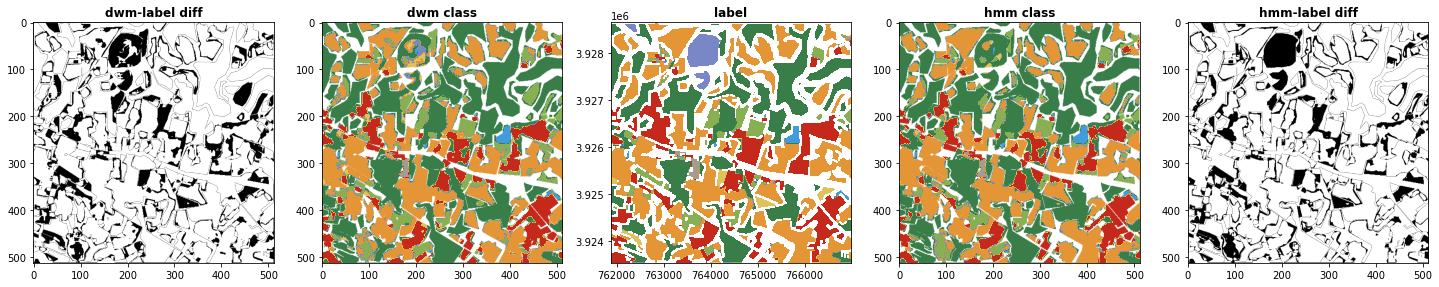

In [10]:
# evaluate top line metrics
year = 2019 # year of label

truevals = labels_tile.read(masked=True)
hmm_predvals = hmms[f'{year}'].read().argmax(axis=0) + 1 # to match label numbering
hmm_predvals = hmm_predvals.reshape(truevals.shape)

dwm_predvals = dwms[f'{year}'].read().argmax(axis=0) + 1 # to match label numbering
dwm_predvals = dwm_predvals.reshape(truevals.shape)

# assign appropriate class names to intergers
unique_int_classes = np.unique([truevals[~truevals.mask].data,hmm_predvals[~truevals.mask]])
valid_sample_labels = np.vectorize(hmm.labels_dict.get)(unique_int_classes)

print('Metrics report for label:DWM comparison')
print(metrics.classification_report(truevals[~truevals.mask], dwm_predvals[~truevals.mask],
                                    zero_division=0,target_names=valid_sample_labels))
print('\nMetrics report for label:HMM comparison')
print(metrics.classification_report(truevals[~truevals.mask], hmm_predvals[~truevals.mask],
                                    zero_division=0,target_names=valid_sample_labels))
print(f'\nClassification agreement with selected label tile for {year}')
hmm.show_label_agreement(dwms,hmms,labels_tile,year)

### Step 5: Compare Dynamic World and HMM postprocessing output

In [11]:
print('DWM-HMM concordance:')
print(metrics.classification_report(dwm_predvals.ravel(), hmm_predvals.ravel(),
                                    zero_division=0,target_names=valid_sample_labels))

cm_arr = metrics.confusion_matrix(dwm_predvals.ravel(), hmm_predvals.ravel())
print('\nDWM-HMM confusion matrix:')
display(hmm.transition_matrix(pd.DataFrame(cm_arr)))
print('\nAdditional metrics:')
display(hmm.all_the_stats(cm_arr).style.format('{:.2f}'))

DWM-HMM concordance:
              precision    recall  f1-score   support

       water       0.95      0.97      0.96      1686
       trees       0.94      1.00      0.97    129074
       grass       0.84      0.72      0.78     25389
 flooded_veg       0.00      0.00      0.00      1176
       crops       0.91      0.92      0.92     70902
       scrub       0.85      0.31      0.46      2677
     builtup       0.97      0.93      0.95     30577
 bare_ground       0.91      0.88      0.90       663

    accuracy                           0.93    262144
   macro avg       0.80      0.72      0.74    262144
weighted avg       0.92      0.93      0.92    262144


DWM-HMM confusion matrix:



Additional metrics:


### Step 6: Characterize change and year-to-year class stability

DWM change:
2016-2017: 0.08
2017-2018: 0.07
2018-2019: 0.12
2019-2020: 0.13

DWM tile frequency of class changes from 2016-2020


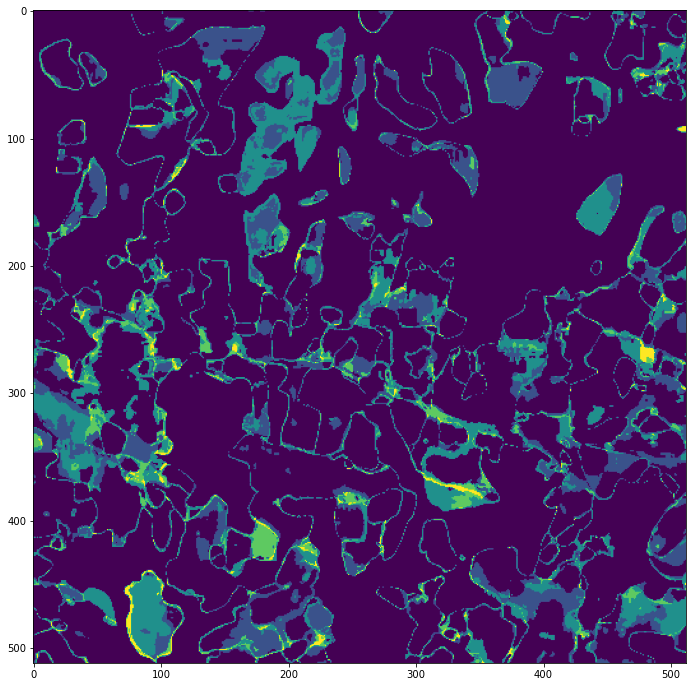


HMM change:
2016-2017: 0.01
2017-2018: 0.01
2018-2019: 0.03
2019-2020: 0.02

HMM frequency of class changes from 2016-2020


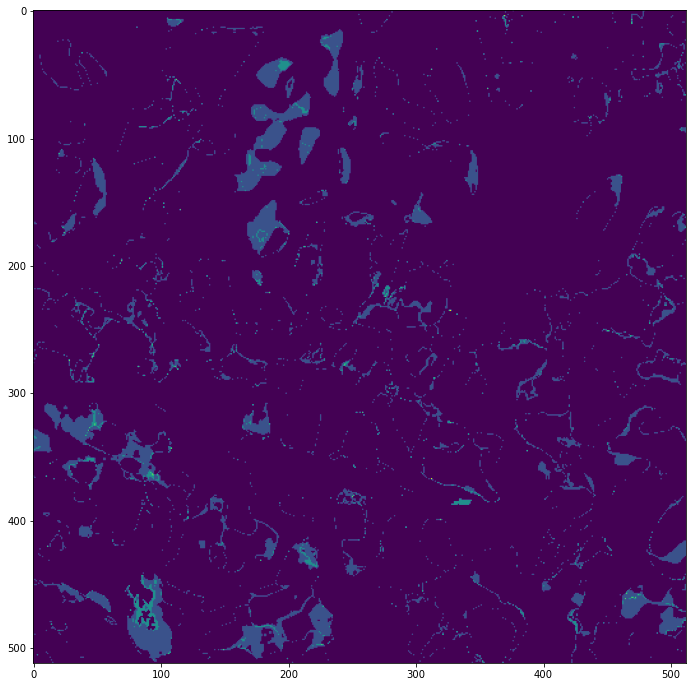

<AxesSubplot:>

In [12]:
print('DWM change:')
hmm.calc_annual_change(dwms, YEARS)
print(f'\nDWM tile frequency of class changes from {YEARS[0]}-{YEARS[-1]}')
show(hmm.number_of_class_changes(dwms,YEARS), vmax=len(YEARS)-1)
print('\nHMM change:')
hmm.calc_annual_change(hmms, YEARS)
print(f'\nHMM frequency of class changes from {YEARS[0]}-{YEARS[-1]}')
show(hmm.number_of_class_changes(hmms,YEARS), vmax=len(YEARS)-1)

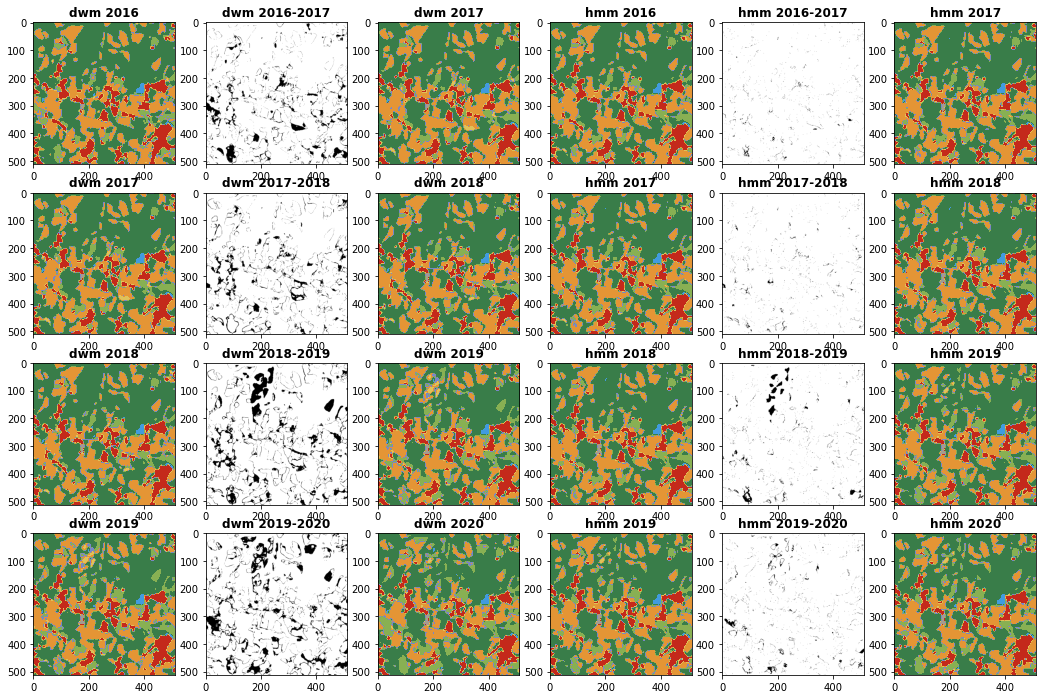

In [13]:
hmm.show_year_diffs_and_classes(dwms,hmms,YEARS)
#hmm.show_year_diffs(dwms,hmms,YEARS)

### Step 7: Explore latent data in class probability distribution

Label confidence for DWM tile, 2019


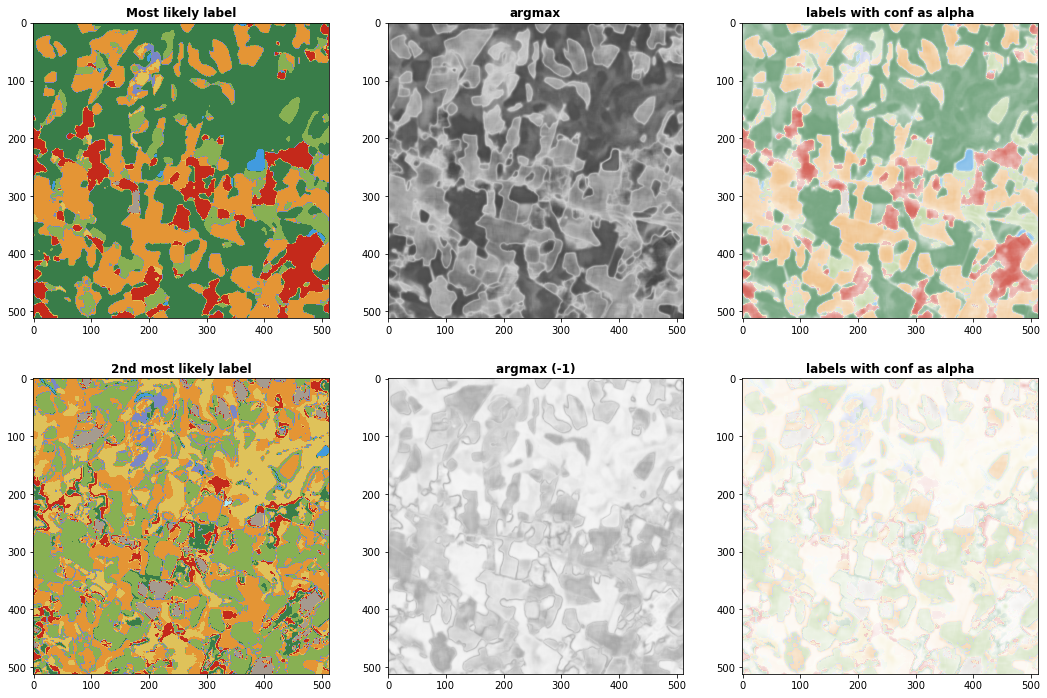

Marginal class probabilities for HMM tile, 2019


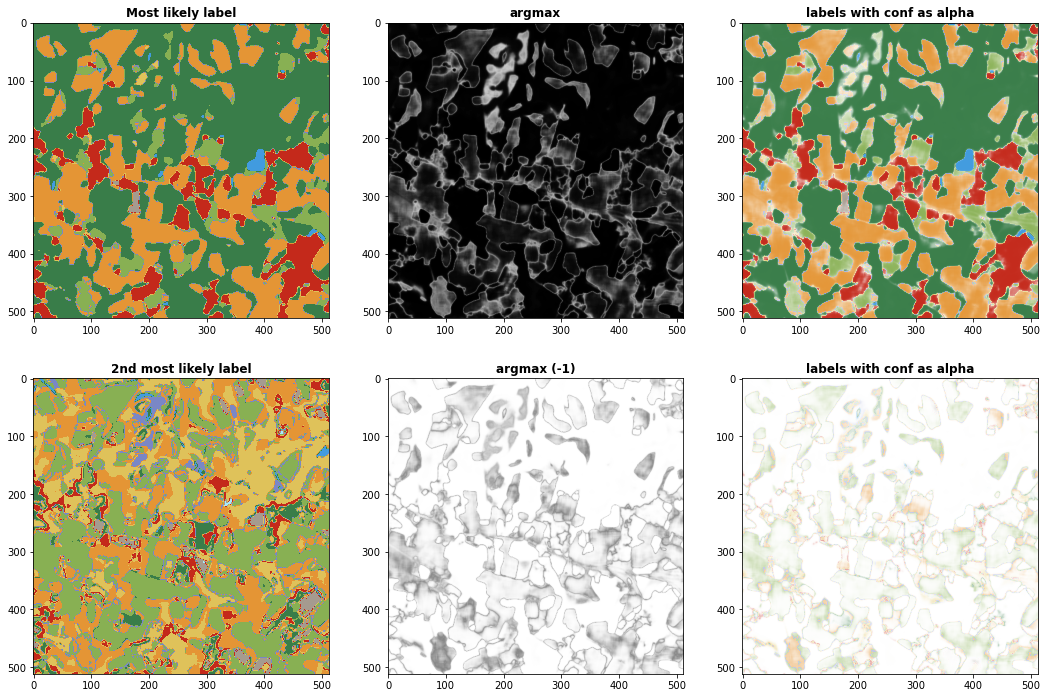

In [14]:
print(f'Label confidence for DWM tile, {year}')
hmm.show_label_confidence(dwms,year)
print(f'Marginal class probabilities for HMM tile, {year}')
hmm.show_label_confidence(hmms,year)

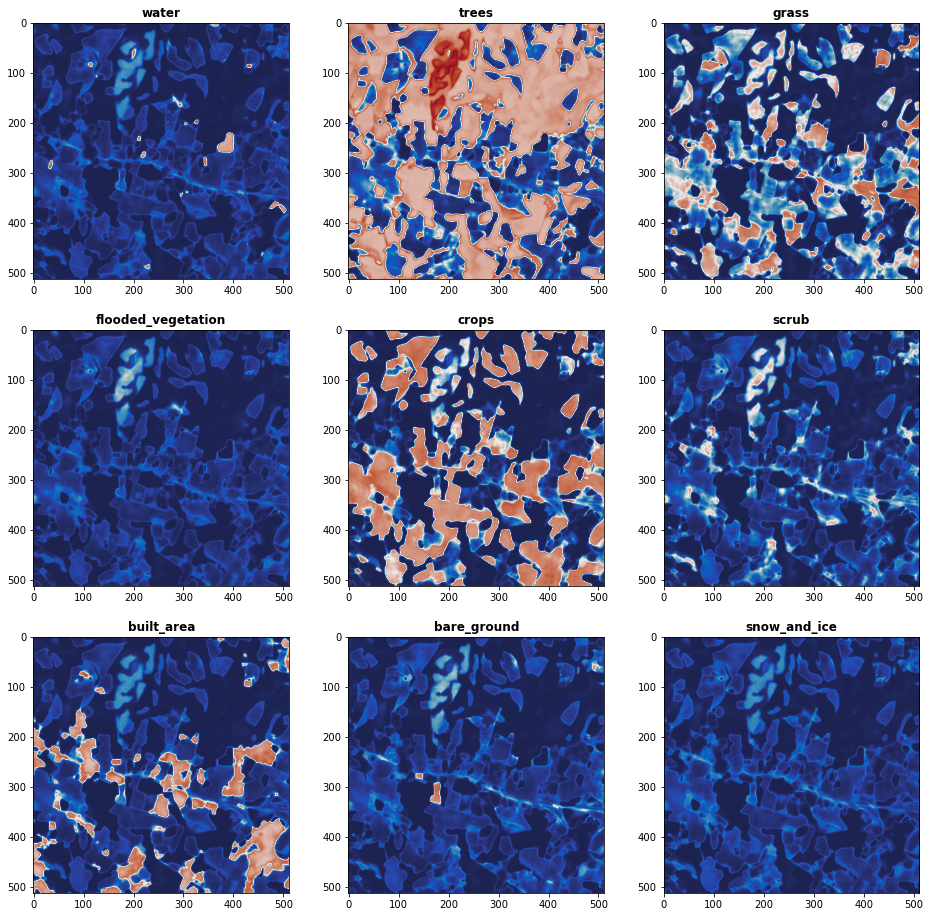

In [15]:
hmm.show_normalized_diff(hmms,dwms,year)

In [16]:
## 
temp_dir_object.cleanup()